In [ ]:
import numpy as np
#np.random.seed(2014)
import matplotlib.pyplot as plt

import dipy.data as dpd
import dipy.reconst.cross_validation as xval
import dipy.reconst.dti as dti
import dipy.reconst.csdeconv as csd
import scipy.stats as stats
from dipy.core.gradients import gradient_table
from dipy.io.image import load_nifti
from dipy.io.gradients import read_bvals_bvecs
from pathlib import Path
import nibabel as nib
from cloudpathlib import S3Path, S3Client

In [ ]:
# Make the path object:
cache_path = Path('/tmp/cache')

# Just because we have made a cache path object doesn't mean that the directory
# we made exists; here we check if it exists and make the directory if not.
if not cache_path.exists():
    cache_path.mkdir()

In [ ]:

client = S3Client(
    local_cache_dir=cache_path,
    no_sign_request=True)

hbn_base_path = S3Path(
    "s3://fcp-indi/",
    client=client)

In [ ]:

# bids_path   = hbn_base_path / 'data' / 'Projects' / 'HBN' / 'MRI'/ 'Site-CUNY'
bids_path = hbn_base_path / "data" / "Projects" / "HBN" / "BIDS_curated" 
sub_code = ["sub-NDARAA948VFH", "sub-NDARAB055BPR"]


In [ ]:
# Set variables on your file names
bids_ses     = 'HBNsiteRU'
bids_acq_anat= 'HCP'
bids_acq_dwi = '64dir'

# Choose on sub to test
bids_sub_idx = 0 
bids_sub     = f'{sub_code[bids_sub_idx]}'
bids_sub

In [22]:
# Load T1w volume
t1_fname = bids_path / bids_sub / f'ses-{bids_ses}' /'anat' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq_anat}_T1w.nii.gz'
t1_data, t1_affine, t1_nii    = load_nifti(t1_fname, return_img=True)

# Set DWI file names
# base_dwi_fname  = bids_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq_dwi}_dwi'
dwi_fname  = bids_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq_dwi}_dwi.nii.gz'
bval_fname = bids_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq_dwi}_dwi.bval'
bvec_fname = bids_path / bids_sub / f'ses-{bids_ses}' / 'dwi' / f'{bids_sub}_ses-{bids_ses}_acq-{bids_acq_dwi}_dwi.bvec'

# Load volume
dwi_data, dwi_affine, dwi_nii = load_nifti(dwi_fname, return_img=True)
dwi_nii = nib.load(dwi_fname)
dwi_data = dwi_nii.get_fdata()
dwi_hdr = dwi_nii.header

In [24]:
# Load bvals and bvecs.
sub01_bvals, sub01_bvecs = read_bvals_bvecs(bval_fname.fspath, bvec_fname.fspath)

print("bval file has a shape of: ", sub01_bvals.shape)  
print("bvec file has a shape of: ", sub01_bvecs.shape)

# Create gradient table.
sub01_gtab = gradient_table(sub01_bvals, sub01_bvecs)
sub01_gtab


cc_vox = dwi_data[40, 70, 38]
cso_vox = dwi_data[30, 76, 38]
NAcc_vox = dwi_data[30, 70, 38]

# Define volumes for seeds. 

bval file has a shape of:  (129,)
bvec file has a shape of:  (129, 3)


In [ ]:
# hardi_fname, hardi_bval_fname, hardi_bvec_fname = dpd.get_fnames('stanford_hardi')

# data, affine = load_nifti(hardi_fname)
# bvals, bvecs = read_bvals_bvecs(hardi_bval_fname, hardi_bvec_fname)
# gtab = gradient_table(bvals, bvecs)






In [25]:
dti_model = dti.TensorModel(sub01_gtab)
response, ratio = csd.auto_response_ssst(sub01_gtab, dwi_data, roi_radii=10, fa_thr=0.7)
csd_model = csd.ConstrainedSphericalDeconvModel(sub01_gtab, response)

In [26]:
dti_cc = xval.kfold_xval(dti_model, cc_vox, 2)
csd_cc = xval.kfold_xval(csd_model, cc_vox, 2, response)
dti_cso = xval.kfold_xval(dti_model, cso_vox, 2)
csd_cso = xval.kfold_xval(csd_model, cso_vox, 2, response)

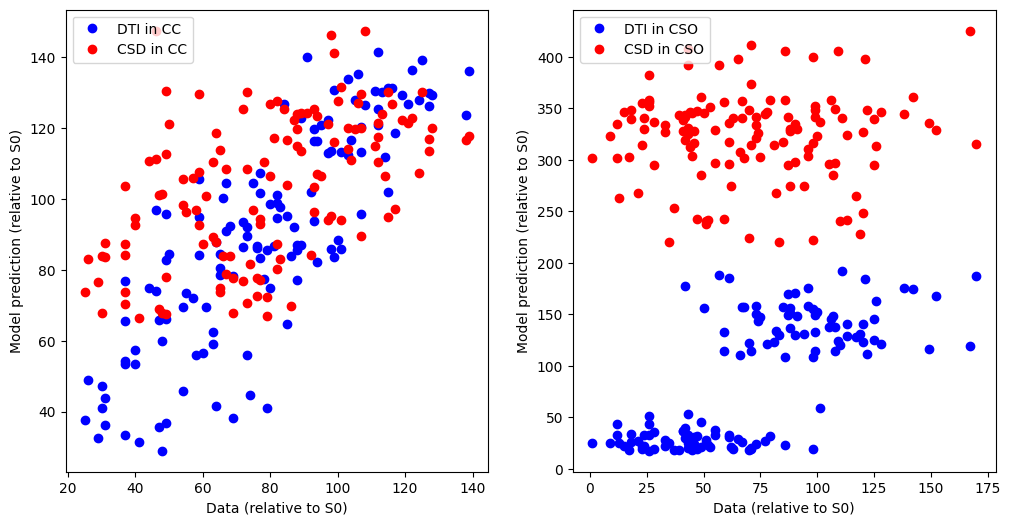

In [27]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches([12, 6])
ax[0].plot(cc_vox[sub01_gtab.b0s_mask == 0], dti_cc[sub01_gtab.b0s_mask == 0], 'o',
           color='b', label='DTI in CC')
ax[0].plot(cc_vox[sub01_gtab.b0s_mask == 0], csd_cc[sub01_gtab.b0s_mask == 0], 'o',
           color='r', label='CSD in CC')
ax[1].plot(cso_vox[sub01_gtab.b0s_mask == 0], dti_cso[sub01_gtab.b0s_mask == 0], 'o',
           color='b', label='DTI in CSO')
ax[1].plot(cso_vox[sub01_gtab.b0s_mask == 0], csd_cso[sub01_gtab.b0s_mask == 0], 'o',
           color='r', label='CSD in CSO')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
for this_ax in ax:
    this_ax.set_xlabel('Data (relative to S0)')
    this_ax.set_ylabel('Model prediction (relative to S0)')
fig.savefig("model_predictions.png")

In [28]:
cc_dti_r2 = stats.pearsonr(cc_vox[sub01_gtab.b0s_mask == 0],
                           dti_cc[sub01_gtab.b0s_mask == 0])[0]**2
cc_csd_r2 = stats.pearsonr(cc_vox[sub01_gtab.b0s_mask == 0],
                           csd_cc[sub01_gtab.b0s_mask == 0])[0]**2
cso_dti_r2 = stats.pearsonr(cso_vox[sub01_gtab.b0s_mask == 0],
                            dti_cso[sub01_gtab.b0s_mask == 0])[0]**2
cso_csd_r2 = stats.pearsonr(cso_vox[sub01_gtab.b0s_mask == 0],
                            csd_cso[sub01_gtab.b0s_mask == 0])[0]**2

print("Corpus callosum\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n"
      "\n"
      "Centrum Semiovale\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n" % (cc_dti_r2, cc_csd_r2, cso_dti_r2, cso_csd_r2))

Corpus callosum
DTI R2 : 0.6858501585309312
CSD R2 : 0.262982914438209

Centrum Semiovale
DTI R2 : 0.5078438398333605
CSD R2 : 0.0006617079885778119

